In [58]:
### v1.1

In [59]:
# Importing the necessary packages

import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
from PIL import Image
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.python.framework import ops
from cnn_utils import *
from test_utils import summary, comparator

%matplotlib inline
np.random.seed(1)

### Loading and Splitting the data

In [60]:
# The task is to build a ConvNet to determine whether the people in the images are smiling or not

In [61]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_happy_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Reshape
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


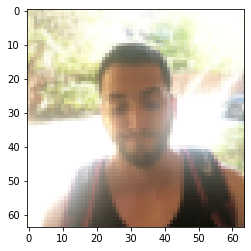

In [62]:
#display sample training image

index = 124
plt.imshow(X_train_orig[index])
plt.show()

### The Sequential API

In [63]:
# GRADED FUNCTION: happyModel

def happyModel():
    """
    Implements the forward propagation for the binary classification model:
    ZEROPAD2D -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    
    Note that for simplicity and grading purposes, you'll hard-code all the values
    such as the stride and kernel (filter) sizes. 
    Normally, functions should take these values as function parameters.
    
    Arguments:
    None

    Returns:
    model -- TF Keras model (object containing the information for the entire training process) 
    """
    model = tf.keras.Sequential([
            ## ZeroPadding2D with padding 3, input shape of 64 x 64 x 3
            tfl.ZeroPadding2D(padding = 3, input_shape = (64,64,3)),
            # In TensorFlow Keras model, we specify the 'input_shape' parameter only for the first layer
        
            ## Conv2D with 32 7x7 filters and stride of 1
            tfl.Conv2D(filters=32, kernel_size=7,strides=1),
            ## BatchNormalization for axis 3
            tfl.BatchNormalization(axis = 3),
            # In BatchNormalization, the 'axis' parameter works differently than the 'axis' parameter in np.sum()
            # While the idea of applying Batch Normalization before Convolutional layers to normalize inputs might seem logical,
            # the established and empirically validated practice is to apply Batch Normalization after Convolutional layers and 
            # before activation functions.
        
            # Applying BatchNormalization before the non-linear activation function ensures that the inputs to the 
            # activation functions have a mean close to 0 and a reduced variance, making the activation outputs more stable.

            ## ReLU
            tfl.ReLU(),
            ## Max Pooling 2D with default parameters
            tfl.MaxPooling2D(),
            ## Flatten layer
            tfl.Flatten(),
            ## Dense layer with 1 unit for output & 'sigmoid' activation
            tfl.Dense(units=1, activation='sigmoid')
            # YOUR CODE STARTS HERE
            
            
            # YOUR CODE ENDS HERE
        ])
    
    return model

# Note

# In the case of batch normalization of neural networks where the data is of the form (m,n) where m is the number of 
# training examples and n is the number of features, the first feature interacts with the first hidden unit. 
# If we fix the mean of the first feature of all training examxples to some value, then the first hidden unit will keep 
# seeing and interacting with the same distribution and the first hidden unit can learn efficiently.

# We don't normalize each training example because network might struggle to learn meaningful distinctions between examples.
# While normalizing each example might preserve relative differences within that example, it can distort the 
# absolute differences between examples. In many learning tasks, these absolute differences are crucial for the model to 
# identify patterns and make accurate predictions.

# In the case of batch normalization of neural networks where the data is of the form (m,n) where m is the number of 
# training examples and n is the number of features, when we batch normalize it along axis = 1, it is different than 
# np.sum(axis = 1). In np.sum(axis=1), the axis=1 dimension is broken down. Whereas in batch_normalization(axis = 1), only the
# axis = 1 direction is preserved.

# In the case of batch normalization of CNN where input data is of shape (m, n_h, n_w, n_c=3) and axis = 3, then 
# batch normalization is carried out along the layers n_c direction. It is carried in such a way that the mean and variance of 
# the first layer of all training examples is fixed. The mean and variance of the second layer of all training examples is 
# fixed and the mean and variance of the third layer of all training examples is fixed.

# How does Batch Normalization along axis = 3 help in efficient learning of weights. Why not axis = 0 or 1 or 2?
# If we do the batch_normalization along axis = 2, it would not make sense because the filter is slided over the input layer.
# So each weight of each layer of the filter would interact with different distributions. Similary for axis = 1, each weight
# of each layer of the filter would interact with different distributions. But when axis = 3, the weights of a particular layer
# of filter would interact with the same distribution. When the layer of filter changes, the distribution changes.

# Batch Normalization in CNN is also not done along axis=0 because in that case we are normalizing each training example. 
# Though the weights of a particular layer of filter would interact with the same distribution and also each layer of filter 
# would interact with the same distribution, we are fixing the mean and variance of each training example which is not
# beneficial as discussed earlier.

In [64]:
happy_model = happyModel()
# Print a summary for each layer
for layer in summary(happy_model):
    print(layer)
    
output = [['ZeroPadding2D', (None, 70, 70, 3), 0, ((3, 3), (3, 3))],
            ['Conv2D', (None, 64, 64, 32), 4736, 'valid', 'linear', 'GlorotUniform'],
            ['BatchNormalization', (None, 64, 64, 32), 128],
            ['ReLU', (None, 64, 64, 32), 0],
            ['MaxPooling2D', (None, 32, 32, 32), 0, (2, 2), (2, 2), 'valid'],
            ['Flatten', (None, 32768), 0],
            ['Dense', (None, 1), 32769, 'sigmoid']]
    
comparator(summary(happy_model), output)

['ZeroPadding2D', (None, 70, 70, 3), 0, ((3, 3), (3, 3))]
['Conv2D', (None, 64, 64, 32), 4736, 'valid', 'linear', 'GlorotUniform']
['BatchNormalization', (None, 64, 64, 32), 128]
['ReLU', (None, 64, 64, 32), 0]
['MaxPooling2D', (None, 32, 32, 32), 0, (2, 2), (2, 2), 'valid']
['Flatten', (None, 32768), 0]
['Dense', (None, 1), 32769, 'sigmoid']
All tests passed!


In [65]:
happy_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [66]:
happy_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_2 (ZeroPaddin (None, 70, 70, 3)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 32)        4736      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
re_lu_6 (ReLU)               (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

### Training and Evaluation of Model

In [67]:
happy_model.fit(X_train, Y_train, epochs=10, batch_size=16)

Epoch 1/10
38/38 [==============================] - 4s 97ms/step - loss: 1.2873 - accuracy: 0.6750
Epoch 2/10
38/38 [==============================] - 4s 95ms/step - loss: 0.2471 - accuracy: 0.9133
Epoch 3/10
38/38 [==============================] - 4s 95ms/step - loss: 0.1665 - accuracy: 0.9350
Epoch 4/10
38/38 [==============================] - 4s 95ms/step - loss: 0.2455 - accuracy: 0.9017
Epoch 5/10
38/38 [==============================] - 4s 95ms/step - loss: 0.1992 - accuracy: 0.9383
Epoch 6/10
38/38 [==============================] - 4s 95ms/step - loss: 0.1060 - accuracy: 0.9633
Epoch 7/10
38/38 [==============================] - 4s 95ms/step - loss: 0.0776 - accuracy: 0.9800
Epoch 8/10
38/38 [==============================] - 4s 95ms/step - loss: 0.0585 - accuracy: 0.9850
Epoch 9/10
38/38 [==============================] - 4s 95ms/step - loss: 0.0489 - accuracy: 0.9800
Epoch 10/10
38/38 [==============================] - 4s 97ms/step - loss: 0.1395 - accuracy: 0.9467


In [68]:
# Prints the 'binary_crossentropy' loss and the 'accuracy'

happy_model.evaluate(X_test, Y_test)

5/5 [==============================] - 0s 38ms/step - loss: 0.4029 - accuracy: 0.8000


[0.4028966724872589, 0.800000011920929]

In [69]:
# The 'Sequential' will not be able to help when we need to build a model with shared layers, branches, or 
# multiple inputs and outputs.

### The Functional API

In [70]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_signs_dataset()

In [71]:
print(X_train_orig.shape)
print(X_test_orig.shape)
print(Y_train_orig.shape)
print(Y_test_orig.shape)

(1080, 64, 64, 3)
(120, 64, 64, 3)
(1, 1080)
(1, 120)


In [72]:
print(Y_train_orig)

[[5 0 2 ... 2 4 5]]


y = 4


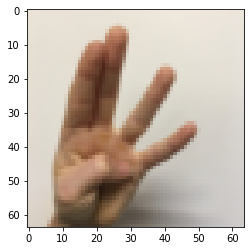

In [73]:
# Example of an image from the dataset
index = 9
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [74]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [75]:
# GRADED FUNCTION: convolutional_model

def convolutional_model(input_shape):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    
    Note that for simplicity and grading purposes, you'll hard-code some values
    such as the stride and kernel (filter) sizes. 
    Normally, functions should take these values as function parameters.
    
    Arguments:
    input_img -- input dataset, of shape (input_shape)

    Returns:
    model -- TF Keras model (object containing the information for the entire training process) 
    """

    input_img = tf.keras.Input(shape=input_shape)
    # In the TensorFlow Keras Functional API, defining the first input layer using tf.keras.Input to specify the 
    # shape (and optionally, the data type) of the input data is a common practice.
    ## CONV2D: 8 filters 4x4, stride of 1, padding 'SAME'
    Z1 = tfl.Conv2D(filters=8, kernel_size=4,strides=1,padding='same')(input_img)
    # When the padding is 'valid', no padding is applied. When the padding is 'same', padding is applied to maintain input size.
    ## RELU
    A1 = tfl.ReLU()(Z1)
    ## MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tfl.MaxPooling2D(pool_size = 8,strides = 8,padding='same')(A1)
    ## CONV2D: 16 filters 2x2, stride 1, padding 'SAME'
    Z2 = tfl.Conv2D(filters=16, kernel_size=2,strides=1,padding='same')(P1)
    ## RELU
    A2 = tfl.ReLU()(Z2)
    ## MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tfl.MaxPooling2D(pool_size = 4,strides = 4,padding='same')(A2)
    ## FLATTEN
    F = tfl.Flatten()(P2)
    ## Dense layer
    ## 6 neurons in output layer. Hint: one of the arguments should be "activation='softmax'" 
    outputs = tfl.Dense(units=6, activation='softmax')(F)
    # YOUR CODE STARTS HERE
    
    
    # YOUR CODE ENDS HERE
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [76]:
conv_model = convolutional_model((64, 64, 3))
conv_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
conv_model.summary()
    
output = [['InputLayer', [(None, 64, 64, 3)], 0],
        ['Conv2D', (None, 64, 64, 8), 392, 'same', 'linear', 'GlorotUniform'],
        ['ReLU', (None, 64, 64, 8), 0],
        ['MaxPooling2D', (None, 8, 8, 8), 0, (8, 8), (8, 8), 'same'],
        ['Conv2D', (None, 8, 8, 16), 528, 'same', 'linear', 'GlorotUniform'],
        ['ReLU', (None, 8, 8, 16), 0],
        ['MaxPooling2D', (None, 2, 2, 16), 0, (4, 4), (4, 4), 'same'],
        ['Flatten', (None, 64), 0],
        ['Dense', (None, 6), 390, 'softmax']]
    
comparator(summary(conv_model), output)

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 8)         392       
_________________________________________________________________
re_lu_7 (ReLU)               (None, 64, 64, 8)         0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 16)          528       
_________________________________________________________________
re_lu_8 (ReLU)               (None, 8, 8, 16)          0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 2, 2, 16)         

In [77]:
# Note

# Both the Sequential and Functional APIs return a TF Keras model object. The only difference is how inputs are 
# handled inside the object model.

### Training the Model

In [78]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(64)
history = conv_model.fit(train_dataset, epochs=100, validation_data=test_dataset)

# We are performing mini-batch gradient descent. We also divide the test dataset into mini-batches because of
# the following reasons :-

# 1) Consistency in Data Processing: This makes sure that data is processed in the same way during both training and testing 
# phases, which can be important if the model is sensitive to batch sizes.
# 2) Memory Efficiency: Evaluating the model on mini-batches of the test dataset requires less memory than processing the 
# entire test set at once.
# 3) Speed: Process the data in mini-batches can be faster than processing it one sample at a time.

Epoch 1/100
17/17 [==============================] - 2s 113ms/step - loss: 1.8306 - accuracy: 0.1694 - val_loss: 1.7904 - val_accuracy: 0.1833
Epoch 2/100
17/17 [==============================] - 2s 106ms/step - loss: 1.7927 - accuracy: 0.1602 - val_loss: 1.7864 - val_accuracy: 0.1833
Epoch 3/100
17/17 [==============================] - 2s 101ms/step - loss: 1.7868 - accuracy: 0.1787 - val_loss: 1.7818 - val_accuracy: 0.1917
Epoch 4/100
17/17 [==============================] - 2s 102ms/step - loss: 1.7811 - accuracy: 0.2194 - val_loss: 1.7718 - val_accuracy: 0.2083
Epoch 5/100
17/17 [==============================] - 2s 106ms/step - loss: 1.7735 - accuracy: 0.2417 - val_loss: 1.7633 - val_accuracy: 0.2333
Epoch 6/100
17/17 [==============================] - 2s 106ms/step - loss: 1.7641 - accuracy: 0.2731 - val_loss: 1.7542 - val_accuracy: 0.2750
Epoch 7/100
17/17 [==============================] - 2s 106ms/step - loss: 1.7541 - accuracy: 0.3426 - val_loss: 1.7422 - val_accuracy: 0.3583

In [79]:
# Note - The history object is an output of the .fit() operation, and provides a record of all the loss and 
# metric values in memory.

### Plotting the loss

In [80]:
history.history

{'loss': [1.8305922746658325,
  1.7926627397537231,
  1.7867575883865356,
  1.781075358390808,
  1.7735270261764526,
  1.7640783786773682,
  1.7540699243545532,
  1.7422616481781006,
  1.7270005941390991,
  1.7096738815307617,
  1.687640905380249,
  1.6577556133270264,
  1.6220303773880005,
  1.585071325302124,
  1.5455740690231323,
  1.5048545598983765,
  1.4648873805999756,
  1.425636887550354,
  1.3868913650512695,
  1.3483775854110718,
  1.3128873109817505,
  1.279641032218933,
  1.2465453147888184,
  1.2147774696350098,
  1.1832376718521118,
  1.1522852182388306,
  1.1220747232437134,
  1.0919338464736938,
  1.064498782157898,
  1.0372424125671387,
  1.0113556385040283,
  0.9869716167449951,
  0.9611202478408813,
  0.9361245632171631,
  0.912200391292572,
  0.8896130323410034,
  0.8689053058624268,
  0.8508985042572021,
  0.8338622450828552,
  0.8167698383331299,
  0.8012918829917908,
  0.7861843109130859,
  0.7723278403282166,
  0.7589275240898132,
  0.745781660079956,
  0.734201

[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Epoch')]

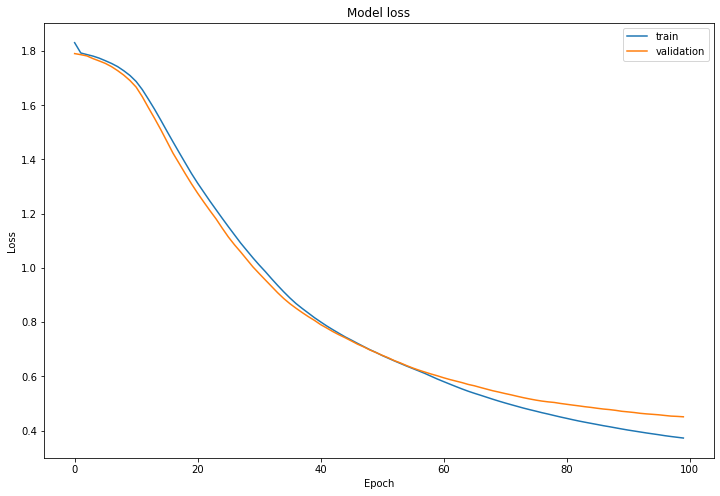

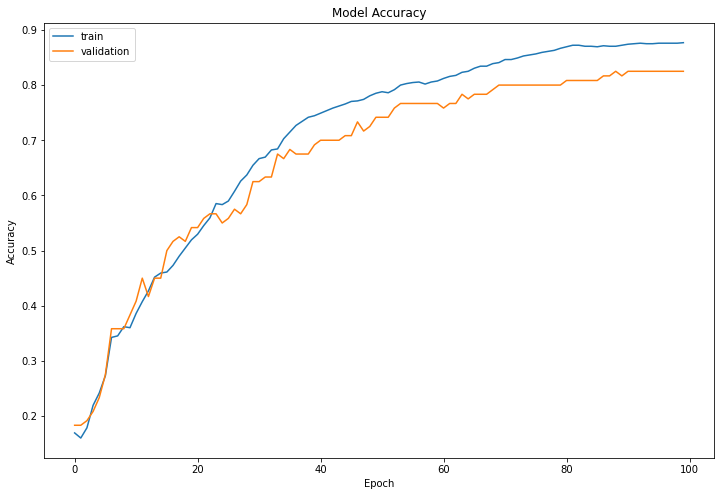

In [81]:
# The history.history["loss"] entry is a dictionary with as many values as epochs that the
# model was trained on. 
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')